<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch06_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 06 — Decision Trees

## 1) Summary
This chapter introduces Decision Trees for **classification** and **regression**:
- How trees split the feature space using axis-aligned rules (CART)
- Impurity measures (Gini / Entropy) and how splits are chosen
- Overfitting and regularization via hyperparameters (e.g., `max_depth`, `min_samples_leaf`)
- Regression trees (piecewise constant predictions)
- Pros/cons: interpretability, minimal preprocessing, but instability and rotation sensitivity

## 2) Learning Goals
- Train a decision tree classifier and interpret its structure.
- Visualize decision boundaries and understand axis-aligned splits.
- Control overfitting using tree hyperparameters.
- Train decision tree regressors and understand piecewise predictions.
- Understand limitations (high variance, sensitive to data changes/rotations).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
def plot_decision_regions(clf, X, y, axes, title=None, grid_steps=200):
    x0s = np.linspace(axes[0], axes[1], grid_steps)
    x1s = np.linspace(axes[2], axes[3], grid_steps)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_grid = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_grid).reshape(x0.shape)

    plt.contourf(x0, x1, y_pred, alpha=0.2)
    plt.contour(x0, x1, y_pred, colors="k", linewidths=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=15)
    plt.xlabel("x1")
    plt.ylabel("x2")
    if title:
        plt.title(title)

## 3) Decision Tree Classification (Iris)

We use **petal length** and **petal width** (2D) for visualization.
Decision Trees create **axis-aligned** splits, producing rectangular regions.

### Theory notes (key ideas)
- CART tries splits that reduce impurity the most.
- Impurity (classification) can use:
  - **Gini**: 1 − Σ p_k²
  - **Entropy**: −Σ p_k log(p_k)
- Trees can fit complex patterns, but can **overfit** without constraints.

In [3]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]           # 0=setosa, 1=versicolor, 2=virginica

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

tree_clf

DecisionTreeClassifier(max_depth=2, random_state=42)

### 3.1 Visualize the trained tree
A shallow tree (e.g., `max_depth=2`) is easier to interpret and less prone to overfitting.

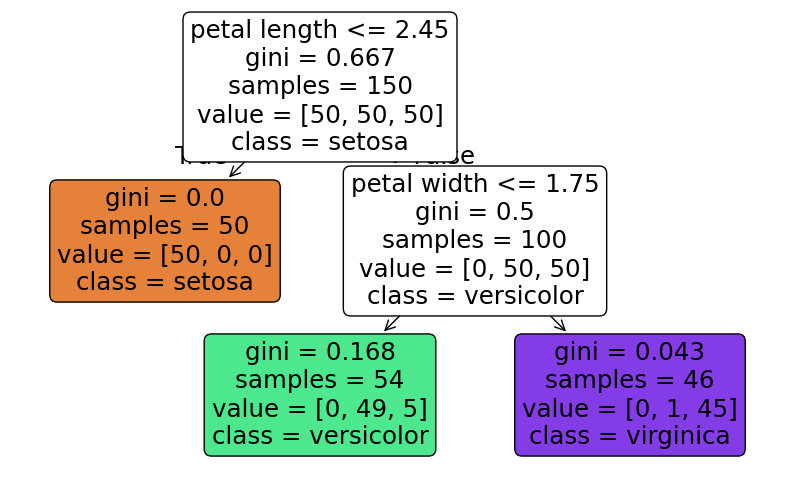

In [4]:
plt.figure(figsize=(10, 6))
plot_tree(
    tree_clf,
    feature_names=["petal length", "petal width"],
    class_names=iris["target_names"],
    filled=True,
    rounded=True
)
plt.show()

### 3.2 Decision boundaries
Decision Trees split along one feature at a time → boundaries look like horizontal/vertical lines.

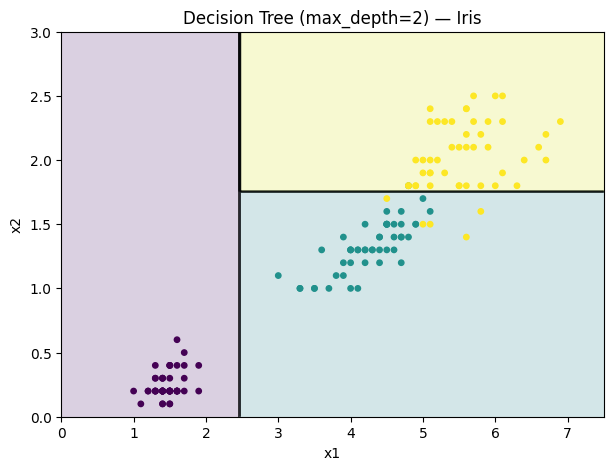

In [5]:
plt.figure(figsize=(7, 5))
plot_decision_regions(tree_clf, X, y, axes=[0, 7.5, 0, 3], title="Decision Tree (max_depth=2) — Iris")
plt.show()

## 4) Overfitting vs Regularization (make_moons)

We use `make_moons` (nonlinear) to show:
- a deep tree can overfit (high variance)
- a constrained tree can generalize better

### Regularization knobs (common)
- `max_depth`
- `min_samples_split`
- `min_samples_leaf`
- `max_leaf_nodes`

In [6]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=42)

deep_tree = DecisionTreeClassifier(random_state=42)  # no constraints
regularized_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=42)

deep_tree.fit(X_train, y_train)
regularized_tree.fit(X_train, y_train)

deep_acc = deep_tree.score(X_test, y_test)
reg_acc = regularized_tree.score(X_test, y_test)

deep_acc, reg_acc

(0.92, 0.89)

### 4.1 Visual comparison of decision boundaries
Deep trees tend to create very jagged boundaries (memorizing noise), while regularized trees are smoother.

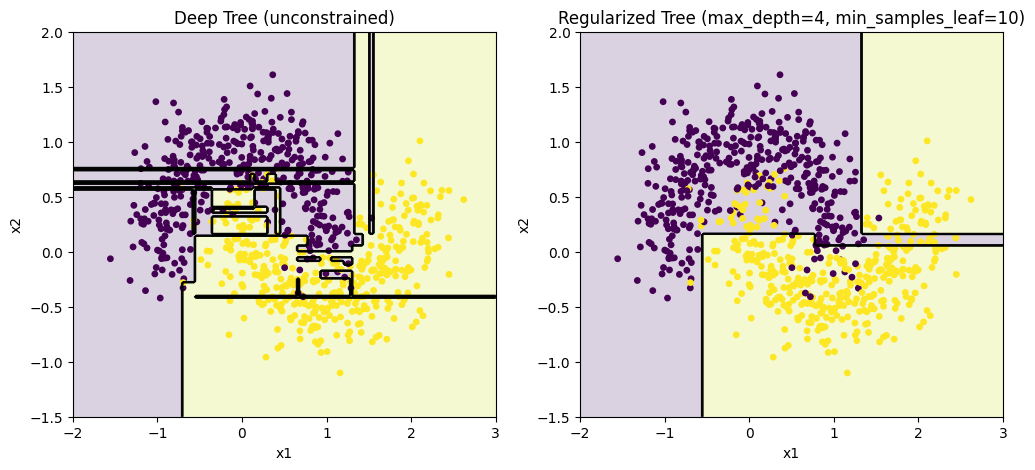

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_decision_regions(deep_tree, X_train, y_train, axes=[-2, 3, -1.5, 2], title="Deep Tree (unconstrained)")

plt.subplot(1, 2, 2)
plot_decision_regions(regularized_tree, X_train, y_train, axes=[-2, 3, -1.5, 2], title="Regularized Tree (max_depth=4, min_samples_leaf=10)")

plt.show()

## 5) Feature Importance

Many tree implementations provide `feature_importances_` (based on impurity reduction).
This gives a quick signal of which features are most useful for splitting.

In [8]:
importances = tree_clf.feature_importances_
for name, imp in zip(["petal length", "petal width"], importances):
    print(f"{name}: {imp:.4f}")

petal length: 0.5620
petal width: 0.4380


## 6) Decision Tree Regression

Regression trees split the input space into regions and predict a constant value per region
(typically the mean of targets in that leaf).

### Theory notes
- Objective is typically MSE reduction by splitting.
- Deeper trees approximate complex functions, but can overfit noise.

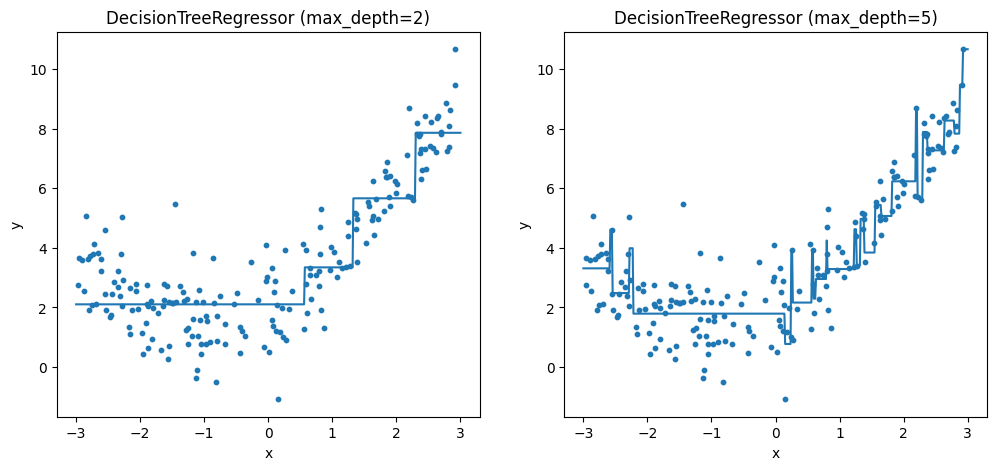

In [9]:
np.random.seed(42)
m = 200
X_reg = np.sort(6 * np.random.rand(m, 1) - 3, axis=0)
y_reg = (0.5 * X_reg**2 + X_reg + 2 + np.random.randn(m, 1)).ravel()

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2 = DecisionTreeRegressor(max_depth=5, random_state=42)

tree_reg1.fit(X_reg, y_reg)
tree_reg2.fit(X_reg, y_reg)

X_new = np.linspace(-3, 3, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(X_new)
y_pred2 = tree_reg2.predict(X_new)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_reg, y_reg, s=10)
plt.plot(X_new, y_pred1)
plt.title("DecisionTreeRegressor (max_depth=2)")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 2, 2)
plt.scatter(X_reg, y_reg, s=10)
plt.plot(X_new, y_pred2)
plt.title("DecisionTreeRegressor (max_depth=5)")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

## 7) A Key Limitation: Rotation Sensitivity (Axis-aligned splits)

Decision Trees split along feature axes. If we rotate the dataset, the “simple” boundary may become harder
to represent with axis-aligned splits, often requiring deeper trees.

Below we compare a tree on the original `make_moons` features vs a rotated version.

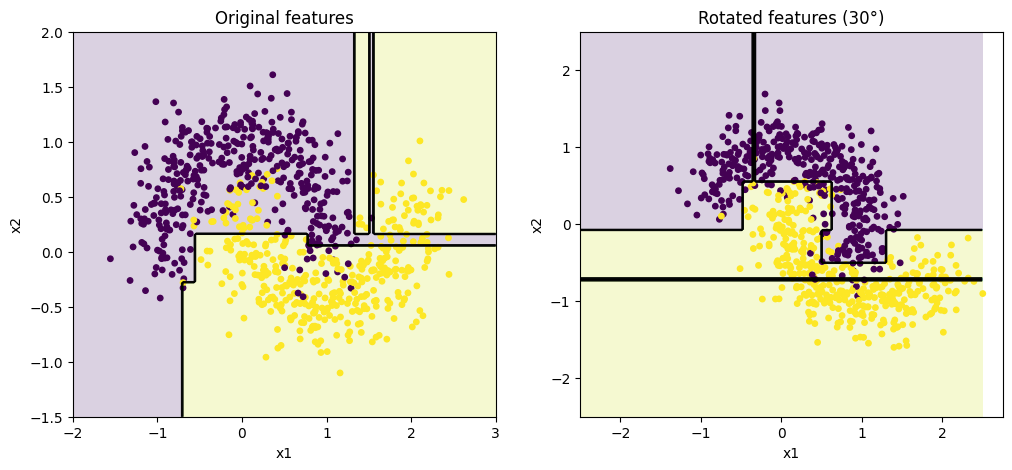

(0.89, 0.96)

In [10]:
# Fit on original features
tree_orig = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_orig.fit(X_train, y_train)

# Rotate features
angle = np.deg2rad(30)
R = np.array([[np.cos(angle), -np.sin(angle)],
              [np.sin(angle),  np.cos(angle)]])

X_train_rot = X_train @ R
X_test_rot = X_test @ R

tree_rot = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_rot.fit(X_train_rot, y_train)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_decision_regions(tree_orig, X_train, y_train, axes=[-2, 3, -1.5, 2], title="Original features")

plt.subplot(1, 2, 2)
plot_decision_regions(tree_rot, X_train_rot, y_train, axes=[-2.5, 2.5, -2.5, 2.5], title="Rotated features (30°)")

plt.show()

tree_orig.score(X_test, y_test), tree_rot.score(X_test_rot, y_test)

## 8) Takeaways
- Decision Trees split the feature space with **axis-aligned rules**; easy to interpret and require little preprocessing.
- Trees can overfit easily → use regularization (`max_depth`, `min_samples_leaf`, etc.).
- Regression trees produce **piecewise constant** predictions.
- Trees are **high-variance** (unstable to data changes) and **rotation-sensitive**.
- Ensembles (Random Forests, Gradient Boosting) often improve performance by reducing variance (next chapters).

## 9) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 6.
- scikit-learn documentation: `DecisionTreeClassifier`, `DecisionTreeRegressor`, `plot_tree`.